# Assignment 3 - 2D Multi Element Airfoil

### Kyle Choy
### MAE 6226

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, linalg
%matplotlib inline

## William's Test Case

Calculate coefficient of pressure on multi-element wing

In [2]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        '''
        Initialize Panel
        
        Set endpoint, calculate center points, set angle wrt x axis of panel 
        '''
        
        self.xa,self.ya = xa,ya #panel start
        self.xb,self.yb = xb,yb #panel end    
        self.xc, self.yc = (xb+xa)/2, (yb+ya)/2
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        #location of panel
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        #initialization
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [3]:
def define_panels(x,y):
    '''
    Discretizes geometry into panels
    '''
    N = x.size-1 #number of panel is number of points minus 1
    
    panels = np.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    
    return panels

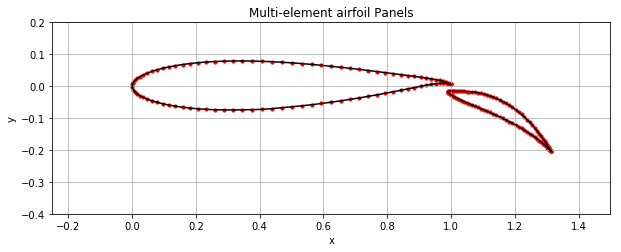

In [4]:
#Load multi element airfoil

flapfoil_filepath = os.path.join('resources', 'FlapFoil_N=100.csv')
with open(flapfoil_filepath, 'r') as infile:
    xf, yf = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True)
    
mainfoil_filepath = os.path.join('resources', 'MainFoil_N=100.csv')
with open(mainfoil_filepath, 'r') as infile:
    xm, ym = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True) 


#Joins the two panel arrays
panelsMain = define_panels(xm,ym)
panelsFlap = define_panels(xf,yf) 

panels = np.concatenate((panelsMain,panelsFlap))

#Lets see how this airfoil looks
width = 10
plt.figure(figsize=(width,width))
plt.title('Multi-element airfoil Panels')
plt.plot(xm,ym,xf,yf, color = 'k')
plt.scatter([panel.xa for panel in panels], [panel.ya for panel in panels],color='r', s = 10)
#plt.scatter([panel.xa for panel in panelsMain], [panel.ya for panel in panelsMain],color='r', s = 10)
#plt.scatter([panel.xa for panel in panelsFlap], [panel.ya for panel in panelsFlap],color='r', s = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.axis('scaled', adjustable = 'box')
plt.xlim(-0.25,1.5)
plt.ylim(-0.4,0.2);

In [5]:
class Freestream:
    def __init__(self,u_inf = 1.0, alpha =0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [6]:
#freestream conditions
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf,alpha)

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

In [7]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x-(panel.xa-np.sin(panel.beta)*s))*dxdk + (y-(panel.ya+np.cos(panel.beta)*s))*dydk)/
                ((x-(panel.xa-np.sin(panel.beta)*s))**2 + (y-(panel.ya+np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

#----------------------------------------------------------------------------------------------------------------#

def source_contrib(panels):
    '''
    Build source contribution matrix for normal velocity
    '''
    
    A = np.empty((panels.size,panels.size), dtype= float)
    
    np.fill_diagonal(A,0.5)
    for i,panel_i in enumerate(panels):
        for j,panel_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/np.pi*integral(panel_i.xc,panel_i.yc,panel_j,np.cos(panel_i.beta),np.sin(panel_i.beta))
    
    return A

#------------------------------------------------------------------------------------------------------------------#

def vortex_contrib(panels):
    '''
    Build vortex contribution matrix for normal velocity
    '''
    
    A = np.empty((panels.size,panels.size), dtype= float)
    
    np.fill_diagonal(A,0.0)
    for i,panel_i in enumerate(panels):
        for j,panel_j in enumerate(panels):
            if i != j:
                A[i,j] = -0.5/np.pi*integral(panel_i.xc,panel_i.yc,panel_j,np.sin(panel_i.beta),-np.cos(panel_i.beta))
    
    return A

Remember that 

* the matrix resulting from the contribution of the vortices on the normal velocity, $B^n$, is **exactly** the matrix resulting from the contribution of the sources on the tangential velocity, $A^t$, i.e.

$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

* the matrix resulting from the contribution of the vortices on the tangential velocity, $B^t$, is the **opposite** of the matrix resulting from the contribution of the sources on the normal velocity, $A^n$, i.e.

$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

In [8]:
A_source = source_contrib(panels)
B_vortex = vortex_contrib(panels)

In [9]:
'''
def kutta(A_source,B_vortex):
    
    b = np.empty((2,A_source.shape[0]+2),dtype=float)
    b[:,-2] = -np.sum(A_source[0,:Na]+A_source[-1,:Na])
    b[:,-1] = -np.sum(A_source[0,Na:]+A_source[-1,Na:]) #Note: -A^n = B^t
    b[0,:-2] = B_vortex[0,:] + B_vortex[Na-1,:] #Note: B^n  = A^t
    b[1,:-2] = B_vortex[Na,:] + B_vortex[-1,:]
    
    return b

def singularity_matrix(A_source,B_vortex):
    
    A = np.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    A[:-2, :-2] = A_source
    
    
    A[:-2,-2] = np.sum(B_vortex[:,:Na], axis=1)
    A[:-2,-1] = np.sum(B_vortex[:,Na:], axis=1)
    
    
    #kutta condition
    A[-2:,:] = kutta(A_source,B_vortex)
   
    return A
'''

'\ndef kutta(A_source,B_vortex):\n    \n    b = np.empty((2,A_source.shape[0]+2),dtype=float)\n    b[:,-2] = -np.sum(A_source[0,:Na]+A_source[-1,:Na])\n    b[:,-1] = -np.sum(A_source[0,Na:]+A_source[-1,Na:]) #Note: -A^n = B^t\n    b[0,:-2] = B_vortex[0,:] + B_vortex[Na-1,:] #Note: B^n  = A^t\n    b[1,:-2] = B_vortex[Na,:] + B_vortex[-1,:]\n    \n    return b\n\ndef singularity_matrix(A_source,B_vortex):\n    \n    A = np.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)\n    A[:-2, :-2] = A_source\n    \n    \n    A[:-2,-2] = np.sum(B_vortex[:,:Na], axis=1)\n    A[:-2,-1] = np.sum(B_vortex[:,Na:], axis=1)\n    \n    \n    #kutta condition\n    A[-2:,:] = kutta(A_source,B_vortex)\n   \n    return A\n'

In [10]:
def kutta_condition(A_source, B_vortex,panels):

    Na = int(panels.size/2)
    b = np.empty((A_source.shape[0],2), dtype=float)
 
    for i, panel in enumerate(panels):
        b[i,0]=np.sum(B_vortex[i,:Na])
        b[i,1]=np.sum(B_vortex[i,Na:])
    
    return b

#----------------------------------------------------------#

def build_singularity_matrix(A_source, B_vortex,panels):
    Na = int(panels.size/2)
    A = np.empty((A_source.shape[0]+2,A_source.shape[0]+2), dtype=float)
    A2 = np.empty((A_source.shape[0],A_source.shape[0]+2),dtype=float)
    a = np.empty((A_source.shape[0],2),dtype=float)
    
    # source contribution matrix
    A[:-2, :-2] = A_source
    
    # Kutta condition array
    A[:-2, -2] = kutta_condition(A_source, B_vortex,panels)[:,0]
    A[:-2, -1] = kutta_condition(A_source, B_vortex,panels)[:,1]
    
    for i, panel in enumerate(panels):
        a[i,0]= -np.sum(A_source[i,:Na])
        a[i,1]=-np.sum(A_source[i,Na:])
    
    A2[:,:-2]= B_vortex
    A2[:,-2]= a[:,0]
    A2[:,-1]=a[:,1]
    
    A3 = np.empty((2,A_source.shape[0]+2),dtype=float)
    A3[0,:]=A2[0,:]+A2[Na-1,:]
    A3[1,:] = A2[Na,:]+A2[-1,:]
    
    A[-2:,:]=A3
    
    return A

In [11]:
def build_freestream_rhs(panels,freestream):
    '''
    build rhs of system from freestream contribution
    '''
    Na = int(panels.size/2)
    
    b = np.empty(panels.size+2,dtype=float)
    
    for i,panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
        
    #kutta condition
    b[-2] = -freestream.u_inf*(np.sin(freestream.alpha-panels[0].beta)+np.sin(freestream.alpha - panels[Na-1].beta))
    b[-1] = -freestream.u_inf*(np.sin(freestream.alpha-panels[Na].beta)+np.sin(freestream.alpha - panels[-1].beta))
    
    return b

In [12]:
#Solve for strengths
Na = int(panels.size/2)

A = build_singularity_matrix(A_source, B_vortex,panels)
b = build_freestream_rhs(panels, freestream)

sigmas = np.linalg.solve(A,b)

for i , panel in enumerate(panels):
    panel.sigma = sigmas[i]

gamma = sigmas[-2:]

#check accuracy
print(sum([panel.sigma*panel.length for panel in panels]))

-0.00174836054324


In [13]:
def compute_tangential_velocity(panels,freestream,gamma,A_source,B_vortex):
    '''
    Compute tangential surface velocity
    '''
    Na = int(panels.size/2)
    A = np.empty((panels.size,panels.size+2),dtype=float)
    
    A[:,:-2] = B_vortex #Note: B^n  = A^t
    A[:,-2] = -np.sum(A_source[:,:Na], axis=1)
    A[:,-1] = -np.sum(A_source[:,Na:], axis=1)
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigmas = np.append([panel.sigma for panel in panels], gamma)
    
    vt = np.dot(A,sigmas) + b 
    
    for i,panel in enumerate(panels):
        panel.vt = vt[i]

In [14]:
def compute_cp(panels,freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [15]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)


# surface pressure coefficient# surfac 
compute_cp(panels, freestream)

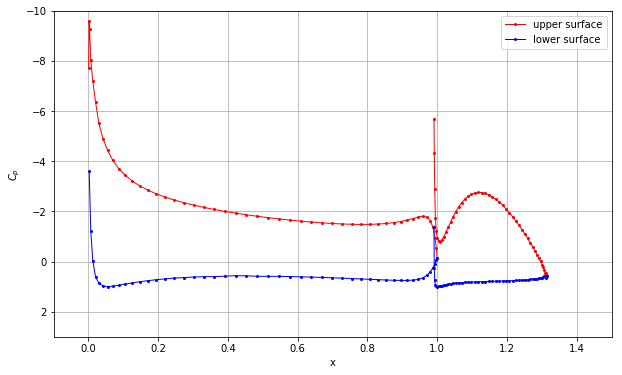

In [16]:
main = panels[:int(panels.size/2)]
flap = panels[int(panels.size/2):]

plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('$C_p$')
plt.grid()
plt.plot([panel.xc for panel in main if panel.loc == 'upper'],[panel.cp for panel in main if panel.loc == 'upper'],
            label='upper surface',color='r', linestyle='-', linewidth=1, marker='o', markersize=2)
plt.plot([panel.xc for panel in flap if panel.loc == 'upper'],[panel.cp for panel in flap if panel.loc == 'upper'],
            color='r', linestyle='-', linewidth=1, marker='o', markersize=2)
plt.plot([panel.xc for panel in main if panel.loc == 'lower'],[panel.cp for panel in main if panel.loc == 'lower'],
            label='lower surface',color='b', linestyle='-', linewidth=1, marker='o', markersize=2)
plt.plot([panel.xc for panel in flap if panel.loc == 'lower'],[panel.cp for panel in flap if panel.loc == 'lower'],
            color='b', linestyle='-', linewidth=1, marker='o', markersize=2)
plt.legend(loc='best')
plt.xlim(-0.1, 1.5)
plt.ylim(3.0, -10.0);

In [17]:
print(main[2].cp)
print(flap[9].cp)

-0.955701172981
-0.279918398369


In [18]:
lift_100 = 0
drag_100 = 0
for panel in panels:
    lift_100 -= panel.cp*panel.length*np.sin(panel.beta)
    drag_100 += panel.cp*panel.length*np.cos(panel.beta)
print(lift_100,drag_100)

3.69771447686 0.0107914032459


### 200 panels

In [19]:
flapfoil_filepath2 = os.path.join('resources', 'FlapFoil_N=200.csv')
with open(flapfoil_filepath2, 'r') as infile:
    xf2, yf2 = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True)
    
mainfoil_filepath2 = os.path.join('resources', 'MainFoil_N=200.csv')
with open(mainfoil_filepath2, 'r') as infile:
    xm2, ym2 = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True)
    
panelsMain2 = define_panels(xm2,ym2)
panelsFlap2 = define_panels(xf2,yf2)
panels2 = np.concatenate((panelsMain2,panelsFlap2))

In [20]:
def get_lift(panels,freestream):
    
    A_source = source_contrib(panels)
    B_vortex = vortex_contrib(panels)
    
    A = build_singularity_matrix(A_source,B_vortex,panels)
    b = build_freestream_rhs(panels,freestream)
    strengths = np.linalg.solve(A,b)
    
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
    gamma = strengths[-2:]
    
    compute_tangential_velocity(panels,freestream,gamma,A_source,B_vortex)
    compute_cp(panels,freestream)
    
    lift = 0
    drag = 0
    
    for panel in panels:
        lift -= panel.cp*panel.length*np.sin(panel.beta)
    
    return lift

In [21]:
Na = int(panels2.size/2)
lift_200 = get_lift(panels2,freestream)
lift_200

3.7184339086812459

In [22]:
lift_theo = 3.7386

err100 = abs(lift_theo - lift_100)
err200 = abs(lift_theo - lift_200)

err_t = (abs(err100-err200)/err100)*100
print(err_t)


50.6766949023


## Wenzinger's Test Case

In [31]:
flapfoil_filepath = os.path.join('resources', 'NACA23012_FlapFoil.csv')
with open(flapfoil_filepath, 'r') as infile:
    xf, yf = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True)
    
mainfoil_filepath = os.path.join('resources', 'NACA23012_MainFoil.csv')
with open(mainfoil_filepath, 'r') as infile:
    xm, ym = np.loadtxt(infile, dtype=float, delimiter=',',unpack=True) 

#Joins the two panel arrays
panelsMain = define_panels(xm,ym)
panelsFlap = define_panels(xf,yf) 


In [32]:
def flap_pitch(x_h,y_h,theta,xf,yf):
    '''
    Determine the flap coordinates for flap pitch
    '''
    
    theta = np.radians(theta)
    x1, y1 = xf - x_h*np.ones_like(xf), yf - y_h*np.ones_like(yf)
    
    x = x1*np.cos(theta)+y1*np.sin(theta)+x_h*np.ones_like(xf)
    y = x1*(-1)*np.sin(theta)+y1*np.cos(theta)+y_h*np.ones_like(yf)
    
    return x, y

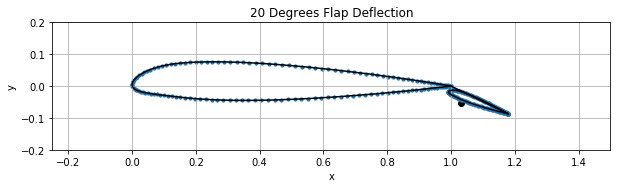

In [33]:
# location of hinge for flap
x_h, y_h = 1.03, -0.054

#pitched flap
pitch = 20
xf_pitch20, yf_pitch20 = flap_pitch(x_h,y_h,pitch,xf,yf)
panelsFlap20 = define_panels(xf_pitch20,yf_pitch20) 

panels = np.concatenate((panelsMain,panelsFlap20))

plt.figure(figsize=(width,width))
plt.scatter(x_h,y_h,color='k')
plt.scatter([panel.xa for panel in panels],[panel.ya for panel in panels],s=10)
plt.plot([panel.xa for panel in panels],[panel.ya for panel in panels],color='k')
plt.axis('scaled', adjustable='box')
plt.title('20 Degrees Flap Deflection')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.xlim(-0.25,1.5)
plt.ylim(-0.2,0.2);

In [34]:
#Compute source and vortex contributions
A_source = source_contrib(panels)
B_vortex = vortex_contrib(panels)

In [27]:
#bisection method
Na = int(panels.size/2)
#initial guesses
alpha_min = -12
alpha_max = 0
alpha_mid = -6
diff = 1.0

while diff > 1e-3: #tolerance
    freestream = Freestream(u_inf=1.0,alpha=alpha_mid)
    lift = get_lift(panels,freestream)
    if lift > 0.0: 
        alpha_max = alpha_mid
    else:
        alpha_min = alpha_mid
        
    alpha_mid = (alpha_max + alpha_min)/2
    
    diff = abs(alpha_max-alpha_min)
    
print('The AoA which would generate zero lift is' alpha_mid, ',generating a lift of',lift)

-10.962894439697266 1.49306035483e-06


In [36]:
freestream = Freestream(u_inf, 0.0) #0 AoA
pitch_min = -20
pitch_max = 20
pitch_mid = (pitch_max+pitch_min)/2
diff = 1.0

while diff > 1e-2:
    #create new panels using assigned pitch
    xf_pitch, yf_pitch= flap_pitch(x_h,y_h,pitch_mid,xf,yf)
    panelsFlap_pitch = define_panels(xf_pitch,yf_pitch)
    panels = np.concatenate((panelsMain, panelsFlap_pitch))
    
    lift2 = get_lift(panels,freestream)

    if lift2 > 0.0: 
        pitch_max = pitch_mid
    else:
        pitch_min = pitch_mid
    
    pitch_mid = (pitch_min + pitch_max)/2
    
    diff = abs(pitch_max-pitch_min)
    
print('The pitch which would generate zero lift is', pitch_mid, ',generating a lift of',lift)

0.0 0.271910644469
-10.0 -0.325750491927
-5.0 -0.0292849385314
-2.5 0.120733957722
-3.75 0.0455783940187
-4.375 0.00811001236129
-4.6875 -0.0105966660811
-4.53125 -0.00124562455172
-4.453125 0.0034316198606
-4.4921875 0.00109285409619
-4.51171875 -7.64211232498e-05
-4.501953125 0.000508207513394
The pitch which would generate zero lift is -4.5068359375 ,generating a lift of 1.49306035483e-06


In [37]:
freestream = Freestream(u_inf, 4.0) #4 AoA (built in)

pitches = np.array([0, 5, 10, 15])
lifts = np.empty(pitches.shape[0], dtype=float)

for i in range(pitches.shape[0]):
    xf_pitch, yf_pitch = flap_pitch(x_h,y_h,pitches[i],xf,yf)
    panelsFlap_pitch = define_panels(xf_pitch,yf_pitch)
    panels = np.concatenate((panelsMain, panelsFlap_pitch))
    lifts[i] = get_lift(panels,freestream)
    
print(lifts)

[ 0.82435976  1.12804895  1.43522694  1.74566936]


In [39]:
#calculate percentage slower the plane can fly in level flight
vdiff = np.empty(pitches.shape[0], dtype=float)

for i in range(pitches.shape[0]):
    vdiff[i] = (1 - np.sqrt(lifts[0])/np.sqrt(lifts[i]))*100
    
print(vdiff)


[  0.          14.51411364  24.21240902  31.28091033]


Having variable pitch flaps allows the aircraft to fly at slower speeds to sustain lift. This is useful because the aircraft will not need to fly very fast on the runway when taking off, therefore taking off sooner and using less runway. Also, the aircraft can make a more controlled landing, since they can take the approach to the runway slower. I imagine this feature would also be helpful in wasting less fuel in situations where the aircraft would need to taxi.